# FYS-STK 4155 H20 PROJECT 1

## Definitions

In [1]:
np.random.seed(0)

In [2]:
# From the assignment; The function that we are goint to approximate
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [3]:
# Generate samples from the FrankeFunction with some optional noise
def franke_sampler(x, y, noise=.1):
    f = FrankeFunction(x, y).reshape(len(x), 1)
    var_eps = noise * np.var(f)
    z = f + np.sqrt(var_eps)*np.random.randn(len(x), 1)
    return (z, f, var_eps)

In [4]:
# Create a mesh with sn uniform randomly scattered points in the rectangle (x_start, y_start), (x_end, y_end). Returned ndarrays have shape (sn, 1)
def randmesh(sn=500, x_start=0., y_start=0., x_end=1., y_end=1.):
    x = np.random.uniform(x_start, x_end, (sn, 1))
    y = np.random.uniform(y_start, y_end, (sn, 1))
    return (x, y)

In [5]:
# Make design matrix with polinomial degree np in two variables
def make_design_matrix(x, y, pn=5):
    X = np.ndarray([len(x), int((pn+1)*(pn+2)/2)])

    ex = [0]*int((pn+1)*(pn+2)/2)
    ey = [0]*int((pn+1)*(pn+2)/2)
    kx = ky = 0
    for i in range(pn+1):
        for j in range(i+1):
            ex[kx] = j
            kx += 1
        for j in range(i,-1,-1):
            ey[ky] = j
            ky += 1

    for i, (xi, yi) in enumerate(zip(x, y)):
        X[i,:] = [(xi**px)*(yi**py) for px, py in zip(ex, ey)]
    
    return X

In [27]:
# Defining some useful functions
def mse(y, y_tilde):
    return np.mean(np.mean((y - y_tilde)**2, axis=1, keepdims=True))

def r2(y, y_tilde):
    return 1 - sum((y - np.mean(y_tilde, axis=1, keepdims=True))**2)/sum((y - np.mean(y))**2)

def bias(f, y_tilde):
    return np.mean((f - np.mean(y_tilde, axis=1, keepdims=True))**2)

def var(y):
    return np.mean(np.var(y, axis=1, keepdims=True))

def scale(X):
    if X.shape[1] == 1:
        return X
    X -= np.mean(X[:,1:])
    X[:,0] = 1
    return X

# NOTE: Choose k such that len(z)%k is zero, ie the split is even!
def split(y, k):
    n = len(y)
    s = n//k  # samples in each split
    last_idx = n - n%k  # remove overshooting samples
    test_splits = [list(range(i, i+s)) for i in range(0, last_idx, s)]
    train_splits = [list(set(range(last_idx)) - set(test_split)) for test_split in test_splits]
    return (train_splits, test_splits)

In [34]:
x, y = randmesh(sn=1000)
z, f, var_eps = franke_sampler(x.T[0], y.T[0], noise=.1)
max_pol_order = 30
bootstraps = 30

## OLS with bootstrap

In [8]:
mse_df = DataFrame()
mse_df["pol order"] = list(range(max_pol_order+1))
mse_df["mse test"] = np.ndarray(max_pol_order+1)
mse_df["mse train"] = np.ndarray(max_pol_order+1)

mse_train = np.ndarray(bootstraps)
mse_test = np.ndarray(bootstraps)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test = skl.model_selection.train_test_split(X, z, train_size=.7)
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        mse_train[bs] = mse(z_resampled, X_resampled @ beta_hat)
        mse_test[bs] = mse(z_test, X_test @ beta_hat)
    
    mse_df.at[pn, "mse train"] = np.mean(mse_train)
    mse_df.at[pn, "mse test"] = np.mean(mse_test)

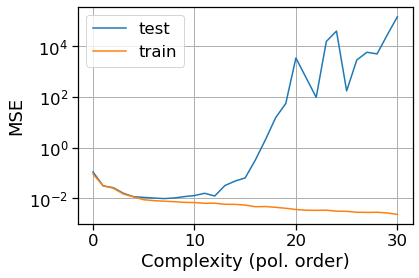

In [9]:
ax = mse_df.plot(x="pol order", logy=True)
ax.legend(["test", "train"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

## OLS bias-variance tradeoff

In [10]:
bivar_df = DataFrame()
bivar_df["pol order"] = list(range(max_pol_order+1))
bivar_df["mse"] = np.ndarray(max_pol_order+1)
bivar_df["bias"] = np.ndarray(max_pol_order+1)
bivar_df["var"] = np.ndarray(max_pol_order+1)

for pn in mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test, f_train, f_test = skl.model_selection.train_test_split(X, z, f, train_size=.7)
    z_test_tilde = np.ndarray((len(z_test), bootstraps))
    X_train = scale(X_train)
    X_test = scale(X_test)
    
    for bs in range(bootstraps):
        X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)
        beta_hat = np.linalg.pinv(X_resampled) @ z_resampled
        z_test_tilde[:, bs] = (X_test @ beta_hat).ravel()
    
    bivar_df.at[pn, "mse"] = mse(z_test, z_test_tilde)
    bivar_df.at[pn, "bias"] = bias(z_test, z_test_tilde)
    bivar_df.at[pn, "var"] = var(z_test_tilde)

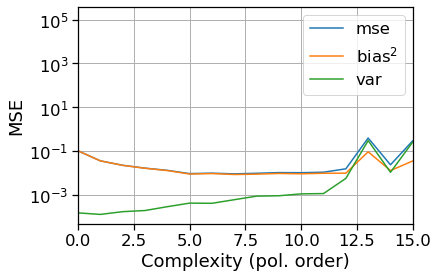

In [11]:
ax = bivar_df.plot(x="pol order", logy=True)
ax.legend(["mse", "bias$^2$", "var"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")
ax.set_xlim(0,15)
#ax.set_ylim(1E-4,1)
ax.grid(True)
plt.show()

## OLS with $k$-fold cross-validation resampling
The data is randomized, so we don't need to do that again.

In [87]:
k = 50
splits = split(z, k)

k_mse_df = DataFrame()
k_mse_df["pol order"] = list(range(max_pol_order+1))
k_mse_df["mse test"] = np.ndarray(max_pol_order+1)
k_mse_df["mse train"] = np.ndarray(max_pol_order+1)

mse_train = np.ndarray(k)
mse_test = np.ndarray(k)

for pn in k_mse_df["pol order"]:
    X = make_design_matrix(x, y, pn=pn)

    for i, (train_split, test_split) in enumerate(zip(*splits)):
        X_train = X[train_split]
        z_train = z[train_split]
        X_test = X[test_split]
        z_test = z[test_split]

        X_train = scale(X_train)
        X_test = scale(X_test)        

        beta_hat = np.linalg.pinv(X_train) @ z_train
        mse_train[i] = mse(z_train, X_train @ beta_hat)
        mse_test[i] = mse(z_test, X_test @ beta_hat)
    
    k_mse_df.at[pn, "mse train"] = np.mean(mse_train)
    k_mse_df.at[pn, "mse test"] = np.mean(mse_test)


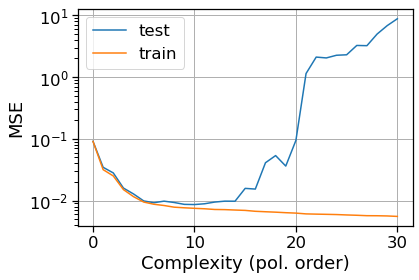

In [88]:
ax = k_mse_df.plot(x="pol order", logy=True)
ax.legend(["test", "train"])
ax.set_xlabel("Complexity (pol. order)")
ax.set_ylabel("MSE")

ax.grid(True)
plt.show()

In [104]:
1 - np.min(k_mse_df["mse test"])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.9048573345121035

## Ridge bias-variance tradeoff

In [48]:
max_pol_order = 11

num_lambdas = 20

train_df = DataFrame()
train_df["lambda"] = np.logspace(-5, 2, num_lambdas)
test_df = DataFrame()
test_df["lambda"] = np.copy(train_df["lambda"])

mse_train = np.ndarray(bootstraps)

pns = list(range(1,max_pol_order+1, 3))
for pn in pns:
    X = make_design_matrix(x, y, pn=pn)
    X_train, X_test, z_train, z_test, _, f_test = skl.model_selection.train_test_split(X, z, f, train_size=.5)
   
    n, p = X_train.shape
    X_train = X_train[:p,:p]
    z_train = z_train[:p]
    X_test = X_test[:p,:p]
    z_test = z_test[:p]
    f_test = f_test[:p]
    
    X_train = scale(X_train)
    X_test = scale(X_test)
   
    train_df[pn] = np.ndarray(num_lambdas)
    test_df[pn] = np.ndarray(num_lambdas)
    test_df[f"{pn} bias"] = np.ndarray(num_lambdas)
    test_df[f"{pn} var"] = np.ndarray(num_lambdas)
    
    z_test_tilde = np.ndarray((p, bootstraps))
    
    for i, lmd in enumerate(train_df["lambda"]):
        L = lmd*np.identity(p)

        for bs in range(bootstraps):
            X_resampled, z_resampled = skl.utils.resample(X_train, z_train, random_state=bs)  
            
            U, s, Vt = np.linalg.svd(X_resampled)
            S = np.diag(s)
            beta_hat = Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T @ z_resampled
            
            mse_train[bs] = mse(z_resampled, X_resampled @ beta_hat)       
            z_test_tilde[:,bs] = (X_test @ beta_hat).ravel()

        train_df.at[i, pn] = np.mean(mse_train)
        test_df.at[i, pn] = mse(z_test, z_test_tilde)
        test_df.at[i, f"{pn} bias"] = bias(f_test, z_test_tilde)
        test_df.at[i, f"{pn} var"] = var(z_test_tilde)

<Figure size 720x360 with 0 Axes>

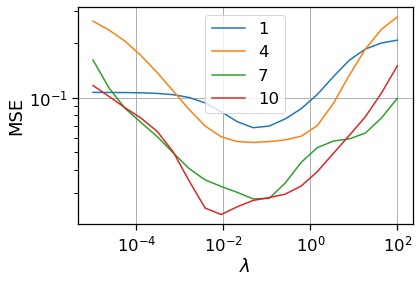

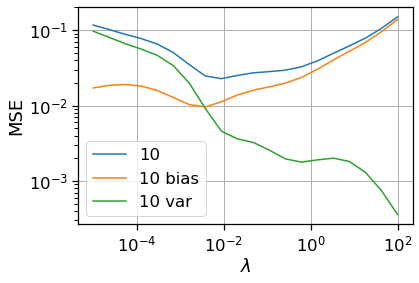

In [50]:
ax = test_df.plot(x="lambda", y=pns, logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

ax = test_df.plot(x="lambda", y=[k:=10, f"{k} bias", f"{k} var"], logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

plt.show()

## Ridge with $k$-fold cross-validation resampling

In [79]:
#max_pol_order = 12

k = 50
num_lambdas = 20

train_df = DataFrame()
train_df["lambda"] = np.logspace(-5, 2, num_lambdas)
test_df = DataFrame()
test_df["lambda"] = np.copy(train_df["lambda"])

mse_train = np.ndarray(k)
mse_test = np.ndarray(k)

pns = list(range(3,max_pol_order+1, 3))
splits = split(z, k)
for pn in pns:
    X = make_design_matrix(x, y, pn=pn)

    train_df[pn] = np.ndarray(num_lambdas)
    test_df[pn] = np.ndarray(num_lambdas)
    
    for i, lmd in enumerate(train_df["lambda"]):
        for j, (train_split, test_split) in enumerate(zip(*splits)):
            X_train = X[train_split]
            z_train = z[train_split]
            X_test = X[test_split]
            z_test = z[test_split]

            n, p = X_train.shape
            X_train = X_train[:p,:p]
            z_train = z_train[:p]
            X_test = X_test[:p,:p]
            z_test = z_test[:p]        
            
            X_train = scale(X_train)
            X_test = scale(X_test)
            
            U, s, Vt = np.linalg.svd(X_train)
            S = np.diag(s)
            L = lmd*np.identity(p)
            beta_hat = Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T @ z_train

            mse_train[j] = mse(z_train, X_train @ beta_hat)
            mse_test[j] = mse(z_test, X_test @ beta_hat)

        train_df.at[i, pn] = np.mean(mse_train)
        test_df.at[i, pn] = np.mean(mse_test)

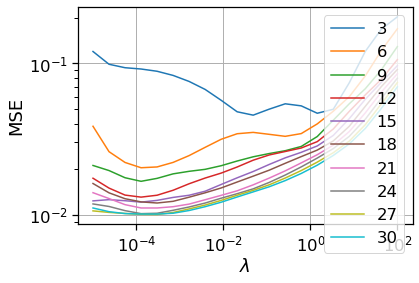

In [112]:
ax = test_df.plot(x="lambda", y=pns, logy=True, logx=True)
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.grid(True)

In [111]:
1 - np.min(test_df[12])/np.mean(sum((z - np.mean(z))**2)/len(z))

0.8562409439360766

In [86]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.inv(S**2 + L) @ S @ U.T))

In [85]:
#plt.figure(figsize=(10,5))
#sns.heatmap(DataFrame(Vt.T @ np.linalg.pinv(X_resampled)))

## LASSO